In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
EPOCHS = 50
CHANNELS = 3

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "dataset",
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [4]:
def get_partitions(ds, train_split=0.8, test_split=0.1, val_split=0.1, shuffle=True, shuffle_size=10000):
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    return train_ds, val_ds, test_ds


In [5]:
train_ds, val_ds, test_ds = get_partitions(dataset)

In [6]:
train_ds = train_ds.cache().shuffle(10000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(10000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(10000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [7]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2)
])

In [8]:
efficientnet_model = EfficientNetB0(include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS))

# Freeze the layers

In [9]:
for layer in efficientnet_model.layers:
    layer.trainable = False

In [10]:
class SqueezeAndExcitation(tf.keras.layers.Layer):
    def __init__(self, ratio=16):
        super(SqueezeAndExcitation, self).__init__()
        self.global_avg_pool = layers.GlobalAveragePooling2D()
        self.dense1 = layers.Dense(efficientnet_model.output.shape[-1] // ratio, activation='relu')
        self.dense2 = layers.Dense(efficientnet_model.output.shape[-1], activation='sigmoid')
        self.reshape = layers.Reshape((1, 1, efficientnet_model.output.shape[-1]))  # Reshape for broadcasting

    def call(self, inputs):
        x = self.global_avg_pool(inputs)
        x = self.dense1(x)
        x = self.dense2(x)
        x = self.reshape(x)  # Reshape for broadcasting
        return inputs * x

In [11]:
se_block = SqueezeAndExcitation()

In [12]:
model = models.Sequential([
    data_augmentation,
    efficientnet_model,
    se_block,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(3, activation='softmax')
])

In [13]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [14]:
history = model.fit(
    train_ds,
    validation_data=val_ds, 
    epochs=EPOCHS
)

Epoch 1/50

54/54 ━━━━━━━━━━━━━━━━━━━━ 129s 2s/step - accuracy: 0.6673 - loss: 0.7417 - val_accuracy: 0.9479 - val_loss: 0.1913
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 89s 2s/step - accuracy: 0.9437 - loss: 0.1912 - val_accuracy: 0.9740 - val_loss: 0.0780
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 88s 2s/step - accuracy: 0.9666 - loss: 0.1126 - val_accuracy: 0.9844 - val_loss: 0.0477
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 88s 2s/step - accuracy: 0.9751 - loss: 0.0773 - val_accuracy: 0.9896 - val_loss: 0.0291
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 88s 2s/step - accuracy: 0.9850 - loss: 0.0472 - val_accuracy: 0.9896 - val_loss: 0.0186
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 87s 2s/step - accuracy: 0.9853 - loss: 0.0479 - val_accuracy: 1.0000 - val_loss: 0.0165
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 88s 2s/step - accuracy: 0.9863 - loss: 0.0514 - val_accuracy: 1.0000 - val_loss: 0.0181
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 88s 2s/step - accuracy: 0.9865 - loss: 0.0335 - val_accuracy: 1.0000 - val_los

Hybrid EfficientNet with Squeeze-and-Excitation for Potato Leaf Disease Classification

In [15]:
test_loss, test_acc = model.evaluate(test_ds)
print(f'Test accuracy: {test_acc}')

8/8 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.9901 - loss: 0.0079
Test accuracy: 0.99609375


In [24]:
model.save("efficientnet_model.keras")

In [16]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [17]:
CLASS_NAMES = ['Class1', 'Class2', 'Class3']

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


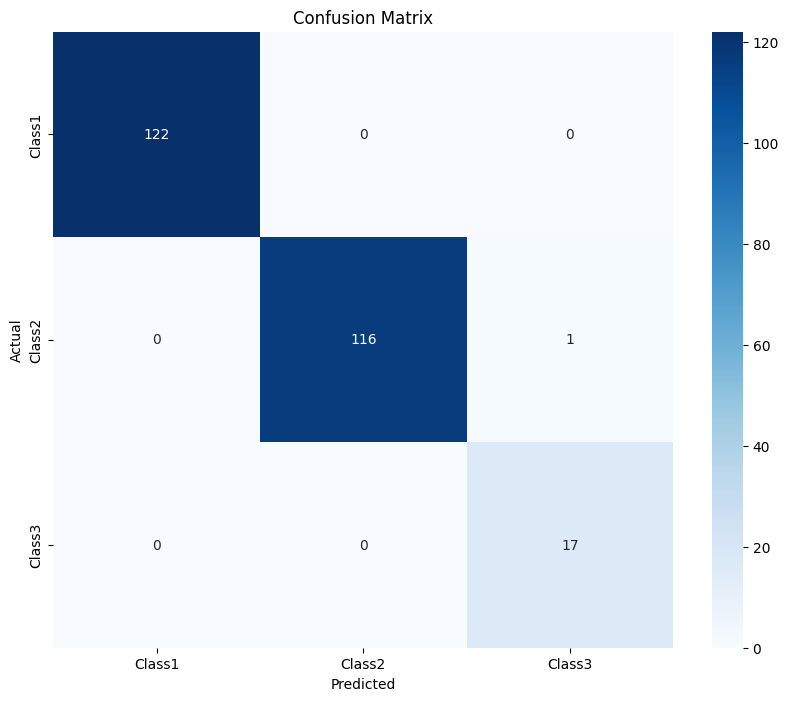

In [18]:
y_true = []
y_pred = []

for images, labels in test_ds:
    predictions = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(predictions, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

conf_mat = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

In [19]:
history.params

{'verbose': 'auto', 'epochs': 50, 'steps': 54}

In [20]:
acc=history.history["accuracy"]
val_acc=history.history["val_accuracy"]
loss=history.history["loss"]
val_loss=history.history["val_loss"]

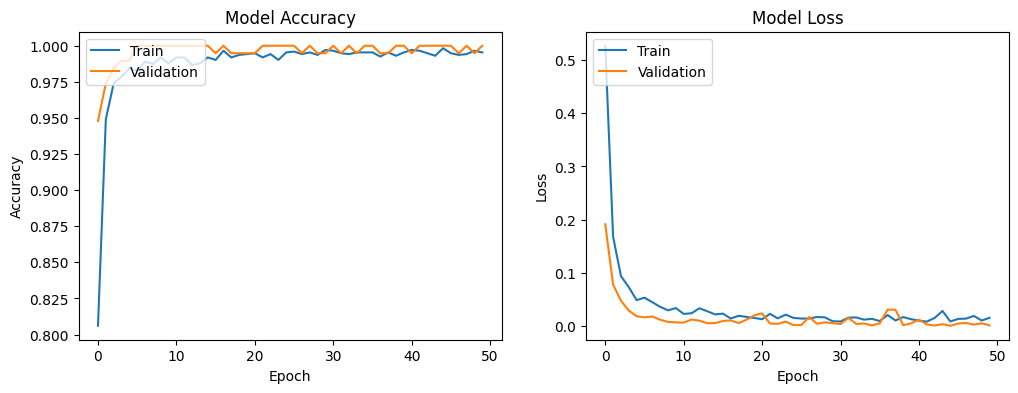

In [22]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [23]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb0 (Functional)          │ (None, 8, 8, 1280)          │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ squeeze_and_excitation               │ (None, 8, 8, 1280)          │         206,160 │
│ (SqueezeAndExcitation)               │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 3)                   │           3,843 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,679,582 (17.85 MB)

 Trainable params: 210,003 (820.32 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

 Optimizer params: 420,008 (1.60 MB)